In [ ]:
#####################################################################################
## Project: macaque SP brain                                                       ##
## Script Purpose: re analysis human fixed SNC                                     ##
## Data: 2022.11.02                                                                ##
## Author: Yiming Sun                                                              ##
#####################################################################################

#sleep
ii <- 1
while(1){
  cat(paste("round",ii),sep = "\n")
  ii <- ii+1
  Sys.sleep(30)
}

In [ ]:
#general setting
setwd('/content/data/sunym/project/Brain')
.libPaths('/home/sunym/env/R_4.2.1/lib/R/library')
Sys.setenv(HDF5_USE_FILE_LOCKING=FALSE,RHDF5_USE_FILE_LOCKING=FALSE)

#library
library(Rmisc)
library(Seurat)
library(ggplot2)
library(dplyr)
library(scibet)
library(Matrix)
library(tidyverse)
library(cowplot)
library(viridis)
library(ComplexHeatmap)
library(parallel)
library(ggsignif)
library(RColorBrewer)
library(ggsci)
library(scales)
library(patchwork)
library(ggpointdensity)
library(latex2exp)
library(ArchR)
library(scales)
library(circlize)
library(ggpubr)
library(ggtext)
library(BSgenome.Hsapiens.UCSC.hg38)
library(BSgenome.Mmulatta.UCSC.rheMac10)
library(UpSetR)
library(ggbreak)
library(ggvenn)
library(EnrichedHeatmap)
library(ChIPseeker)
library(org.Hs.eg.db)
library(org.Mmu.eg.db)
library(DESeq2)
library(topGO)
library(clusterProfiler)

#my function
source('https://raw.githubusercontent.com/yimingsun12138/source_list/main/sc_multiomics.R')
source('https://raw.githubusercontent.com/yimingsun12138/source_list/main/genomics.R')
source('/content/script/twilio_send_messages.R')

#initialize ArchR
addArchRThreads(threads = 5)

## Get human SNC

In [ ]:
#load data
Greenleaf_ATAC_ArchR <- loadArchRProject(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/')
human_SNC <- readRDS(file = './data/public/The_cis_regulatory_effects_of_modern_human_specific_variants/processed_data/SNC_GRanges.rds')
color_param <- readRDS(file = './data/parameter/shared_param/MetaValue_color_param_220923.rds')

In [ ]:
#extent +- 250 bp
names(human_SNC) <- paste(human_SNC@seqnames,as.character(human_SNC@ranges),sep = '-')
meta_data <- human_SNC@elementMetadata
extented_human_SNC <- rtracklayer::as.data.frame(human_SNC)
extented_human_SNC <- extented_human_SNC[,c('seqnames','start','end')]

extented_human_SNC$start <- extented_human_SNC$start - 250
extented_human_SNC$start[c(extented_human_SNC$start < 0)] <- 0
extented_human_SNC$end <- extented_human_SNC$end + 250
colnames(extented_human_SNC) <- c('chrom','start','end')
extented_human_SNC <- as(extented_human_SNC,'GRanges')

#add metadata
extented_human_SNC$human_SNC <- names(human_SNC)
table(names(extented_human_SNC) == extented_human_SNC$human_SNC)

meta_data <- cbind(extented_human_SNC@elementMetadata,meta_data)
extented_human_SNC@elementMetadata <- meta_data

#rename
names(extented_human_SNC) <- paste(extented_human_SNC@seqnames,as.character(extented_human_SNC@ranges),sep = '-')

In [ ]:
#save data
saveRDS(object = extented_human_SNC,file = './res/step_72_fig_221101/extented_human_SNC.rds')

In [ ]:
#intersect with human cell type peaks
cell_type_list <- names(color_param$celltype)
cell_type_list <- cell_type_list[c(cell_type_list %in% Greenleaf_ATAC_ArchR$cell_type)]

for(i in cell_type_list){
    cell_type_dot <- gsub(pattern = '-',replacement = '.',x = i,fixed = TRUE)
    
    #get peak file
    peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
    peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
    peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
    file.exists(peak_file) %>% print()
    peak_file <- readRDS(file = peak_file)
    
    #count overlap
    temp <- countOverlaps(query = extented_human_SNC,subject = peak_file)
    extented_human_SNC@elementMetadata[temp == 0,cell_type_dot] <- 'NO'
    extented_human_SNC@elementMetadata[temp > 0,cell_type_dot] <- 'YES'
}

In [ ]:
#validate using previous data
temp <- readRDS(file = './res/step_67_fig_221021/extent_plot/SNC_GRanges.rds')
(extented_human_SNC$`Ex.1` == temp$`Ex.1`) %>% table()

extented_human_SNC@ranges@width %>% table()
#seems no problem

## liftover to macaque genome

In [ ]:
#load data
human_SNC <- readRDS(file = './data/public/The_cis_regulatory_effects_of_modern_human_specific_variants/processed_data/SNC_GRanges.rds')
extented_human_SNC <- readRDS(file = './res/step_72_fig_221101/extented_human_SNC.rds')
color_param <- readRDS(file = './data/parameter/shared_param/MetaValue_color_param_220923.rds')

macaque_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/')

In [ ]:
#rename human SNC
names(human_SNC) <- paste(human_SNC@seqnames,as.character(human_SNC@ranges),sep = '-')
names(extented_human_SNC) <- extented_human_SNC$human_SNC
(names(human_SNC) == names(extented_human_SNC)) %>% table()

In [ ]:
#liftover to macaque genome
macaque_SNC <- my_rtracklayer_liftOver(ori_GRanges = human_SNC,
                                       chain_file = './data/reference/UCSC_chain_file_for_liftOver/hg38ToRheMac10.over.chain',
                                       merge = FALSE)

duplicated(macaque_SNC$ori_peak) %>% table()
(macaque_SNC$ori_peak %in% extented_human_SNC$human_SNC) %>% table()
#all right

#extent +-250 bp
extented_macaque_SNC <- rtracklayer::as.data.frame(macaque_SNC)
extented_macaque_SNC <- extented_macaque_SNC[,c('seqnames','start','end')]

extented_macaque_SNC$start <- extented_macaque_SNC$start - 250
extented_macaque_SNC$start[c(extented_macaque_SNC$start < 0)] <- 0
extented_macaque_SNC$end <- extented_macaque_SNC$end + 250
colnames(extented_macaque_SNC) <- c('chrom','start','end')
extented_macaque_SNC <- as(extented_macaque_SNC,'GRanges')

#add meta data
extented_macaque_SNC$human_SNC <- macaque_SNC$ori_peak
extented_macaque_SNC$macaque_SNC <- paste(macaque_SNC@seqnames,as.character(macaque_SNC@ranges),sep = '-')

#add original meta_data
names(human_SNC) <- paste(human_SNC@seqnames,as.character(human_SNC@ranges),sep = '-')
meta_data <- human_SNC[c(extented_macaque_SNC$human_SNC)]@elementMetadata
meta_data <- cbind(extented_macaque_SNC@elementMetadata,meta_data)
extented_macaque_SNC@elementMetadata <- meta_data

#rename extented_macaque_SNC
names(extented_macaque_SNC) <- paste(extented_macaque_SNC@seqnames,as.character(extented_macaque_SNC@ranges),sep = '-')

In [ ]:
#save data
saveRDS(object = extented_macaque_SNC,file = './res/step_72_fig_221101/macaque_lifted_SNC/extented_macaque_SNC.rds')

In [ ]:
#save extented human SNC
extented_human_SNC <- readRDS(file = './res/step_72_fig_221101/extented_human_SNC.rds')
names(extented_human_SNC) <- extented_human_SNC$human_SNC
extented_human_SNC <- extented_human_SNC[c(extented_macaque_SNC$human_SNC)]

names(extented_human_SNC) <- paste(extented_human_SNC@seqnames,as.character(extented_human_SNC@ranges),sep = '-')

saveRDS(object = extented_human_SNC,file = './res/step_72_fig_221101/macaque_lifted_SNC/extented_human_SNC.rds')

In [ ]:
#consistency with ori data
(extented_human_SNC$archaic_nucleotide == extented_macaque_SNC$archaic_nucleotide) %>% table()

In [ ]:
#overlap with macaque cell type peaks
cell_type_list <- names(color_param$celltype)
cell_type_list <- cell_type_list[c(cell_type_list %in% macaque_multiome_ArchR$cell_type)]

for(i in cell_type_list){
    cell_type_dot <- gsub(pattern = '-',replacement = '.',x = i,fixed = TRUE)
    
    #get peak file
    peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
    peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
    peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
    file.exists(peak_file) %>% print()
    peak_file <- readRDS(file = peak_file)
    
    #count overlap
    temp <- countOverlaps(query = extented_macaque_SNC,subject = peak_file)
    extented_macaque_SNC@elementMetadata[temp == 0,cell_type_dot] <- 'NO'
    extented_macaque_SNC@elementMetadata[temp > 0,cell_type_dot] <- 'YES'
}

In [ ]:
#check wit previous data
temp <- readRDS(file = './res/step_69_fig_221022/SNC_macaque.rds')

names(extented_macaque_SNC) <- extented_macaque_SNC$human_SNC
extented_macaque_SNC <- extented_macaque_SNC[c(temp$ori_peak)]

(extented_macaque_SNC$`Ex.2` == temp$`Ex.2`) %>% table()

#all right

## filter SNC using sequence difference

In [ ]:
#load data
human_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC/extented_human_SNC.rds')
macaque_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC/extented_macaque_SNC.rds')

In [ ]:
#get macaque seq
temp <- base::do.call(what = rbind,args = strsplit(x = macaque_SNC$macaque_SNC,split = '-'))
temp <- as.data.frame(temp)
colnames(temp) <- c('chrom','start')
temp$end <- temp$start
temp <- as(temp,'GRanges')

i <- BSgenome::getSeq(x = BSgenome.Mmulatta.UCSC.rheMac10,name = temp,as.character = TRUE)
macaque_SNC$macaque_nucleotide <- i

In [ ]:
#venn plot
temp <- list(human = paste(macaque_SNC$human_SNC,macaque_SNC$modern_nucleotide,sep = '-'),
             archaic = paste(macaque_SNC$human_SNC,macaque_SNC$archaic_nucleotide,sep = '-'),
             macaque = paste(macaque_SNC$human_SNC,macaque_SNC$macaque_nucleotide,sep = '-'))

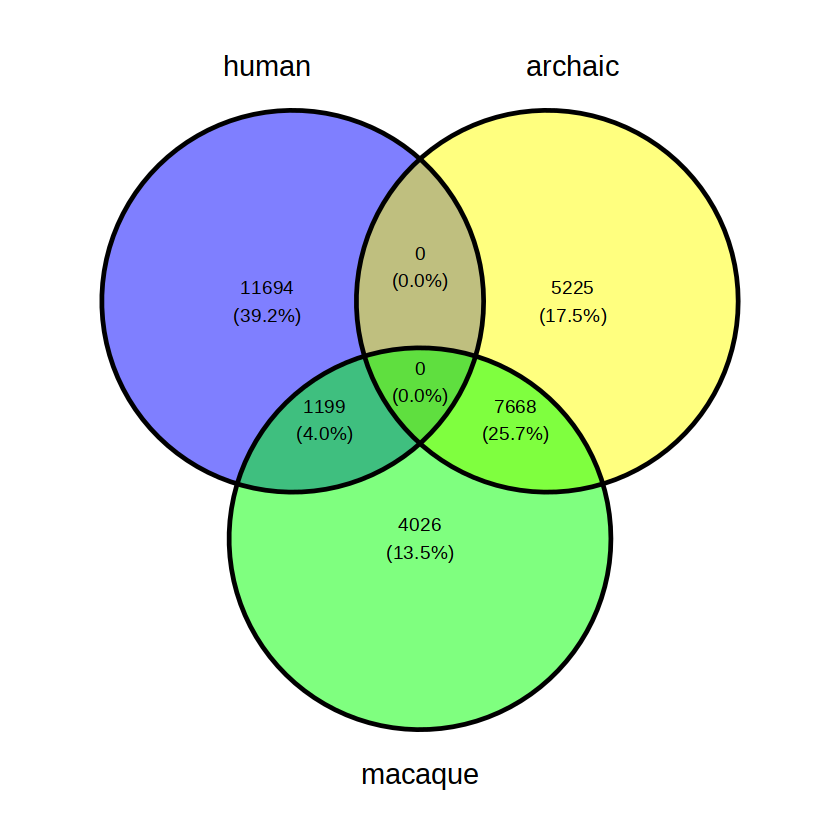

In [18]:
ggvenn(data = temp,columns = c('human','archaic','macaque'))

In [ ]:
#filter SNC shared between human and macaque
macaque_SNC <- macaque_SNC[c(macaque_SNC$modern_nucleotide != macaque_SNC$macaque_nucleotide)]

In [ ]:
#save data
extented_macaque_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC/extented_macaque_SNC.rds')
extented_human_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC/extented_human_SNC.rds')

names(macaque_SNC) <- macaque_SNC$human_SNC
names(extented_macaque_SNC) <- extented_macaque_SNC$human_SNC

#macaque
extented_macaque_SNC <- extented_macaque_SNC[c(names(macaque_SNC))]
extented_macaque_SNC$macaque_nucleotide <- macaque_SNC$macaque_nucleotide

#human
names(extented_human_SNC) <- extented_human_SNC$human_SNC
names(extented_macaque_SNC) <- extented_macaque_SNC$human_SNC
extented_human_SNC <- extented_human_SNC[c(names(extented_macaque_SNC))]

#save data
names(extented_macaque_SNC) <- paste(extented_macaque_SNC@seqnames,as.character(extented_macaque_SNC@ranges),sep = '-')
saveRDS(object = extented_macaque_SNC,file = './res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_macaque_SNC.rds')

names(extented_human_SNC) <- paste(extented_human_SNC@seqnames,as.character(extented_human_SNC@ranges),sep = '-')
saveRDS(object = extented_human_SNC,file = './res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_human_SNC.rds')

In [ ]:
#check with previous data
temp <- readRDS(file = './res/step_69_fig_221022/SNC_macaque.rds')

names(temp) <- temp$ori_peak
names(extented_macaque_SNC) <- extented_macaque_SNC$human_SNC

length(temp) == length(extented_macaque_SNC)
(names(temp) %in% names(extented_macaque_SNC)) %>% table()

temp <- temp[c(names(extented_macaque_SNC))]
(temp$modern_nucleotide == extented_macaque_SNC$modern_nucleotide) %>% table()

#all right!

## DF test between human and macaque

### generate human peak matrix

In [ ]:
#setwd
setwd('/home/sunym/temp')
#load data
human_SNC <- readRDS(file = '/content/data/sunym/project/Brain/res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_human_SNC.rds')
Greenleaf_ATAC_ArchR <- loadArchRProject(path = '/content/data/sunym/project/Brain/processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/')

In [ ]:
#re create ArchR project
temp <- getArrowFiles(ArchRProj = Greenleaf_ATAC_ArchR)
file.exists(temp)
temp <- ArchRProject(
  ArrowFiles = temp,
  outputDirectory = '/home/sunym/temp/Greenleaf_ATAC_ArchR',
  copyArrows = TRUE,
  geneAnnotation = getGeneAnnotation(ArchRProj = Greenleaf_ATAC_ArchR),
  genomeAnnotation = getGenomeAnnotation(ArchRProj = Greenleaf_ATAC_ArchR)
)

temp <- temp[rownames(Greenleaf_ATAC_ArchR@cellColData)]
temp$cell_type <- Greenleaf_ATAC_ArchR$cell_type
table(temp$cell_type)
temp <- addPeakSet(ArchRProj = temp,peakSet = human_SNC)
temp <- addPeakMatrix(ArchRProj = temp)
getAvailableMatrices(ArchRProj = temp)

human_peak_matrix <- getMatrixFromProject(ArchRProj = temp,useMatrix = 'PeakMatrix',verbose = TRUE)
gene_list <- paste(human_peak_matrix@rowRanges@seqnames,as.character(human_peak_matrix@rowRanges@ranges),sep = '-')
human_peak_matrix <- human_peak_matrix@assays@data$PeakMatrix
rownames(human_peak_matrix) <- gene_list

saveRDS(object = human_peak_matrix,file = '/content/data/sunym/project/Brain/res/step_72_fig_221101/human_peak_matrix.rds')

### generate macaque peak matrix

In [ ]:
#setwd
setwd('/home/sunym/temp')
#load data
macaque_SNC <- readRDS(file = '/content/data/sunym/project/Brain/res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_macaque_SNC.rds')
macaque_multiome_ArchR <- loadArchRProject(path = '/content/data/sunym/project/Brain/processed_data/221008_summary/macaque_multiome_ArchR_221011/')

In [ ]:
#re create ArchR project
temp <- getArrowFiles(ArchRProj = macaque_multiome_ArchR)
file.exists(temp)
temp <- ArchRProject(
  ArrowFiles = temp,
  outputDirectory = '/home/sunym/temp/macaque_multiome_ArchR',
  copyArrows = TRUE,
  geneAnnotation = getGeneAnnotation(ArchRProj = macaque_multiome_ArchR),
  genomeAnnotation = getGenomeAnnotation(ArchRProj = macaque_multiome_ArchR)
)
temp <- temp[rownames(macaque_multiome_ArchR@cellColData)]
temp$cell_type <- macaque_multiome_ArchR$cell_type
table(temp$cell_type)
temp <- addPeakSet(ArchRProj = temp,peakSet = macaque_SNC)
temp <- addPeakMatrix(ArchRProj = temp)
getAvailableMatrices(ArchRProj = temp)

macaque_peak_matrix <- getMatrixFromProject(ArchRProj = temp,useMatrix = 'PeakMatrix',verbose = TRUE)
gene_list <- paste(macaque_peak_matrix@rowRanges@seqnames,as.character(macaque_peak_matrix@rowRanges@ranges),sep = '-')
macaque_peak_matrix <- macaque_peak_matrix@assays@data$PeakMatrix
rownames(macaque_peak_matrix) <- gene_list

saveRDS(object = macaque_peak_matrix,file = '/content/data/sunym/project/Brain/res/step_72_fig_221101/macaque_peak_matrix.rds')

### first try using IP

In [ ]:
#load data
human_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_human_SNC.rds')
macaque_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_macaque_SNC.rds')

human_peak_matrix <- readRDS(file = './res/step_72_fig_221101/human_peak_matrix.rds')
macaque_peak_matrix <- readRDS(file = './res/step_72_fig_221101/macaque_peak_matrix.rds')

Greenleaf_ATAC_ArchR <- loadArchRProject(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/')
macaque_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/')

color_param <- readRDS(file = './data/parameter/shared_param/MetaValue_color_param_220923.rds')

In [ ]:
#set cell type
cell_type <- 'IP'
cell_type_dot <- gsub(pattern = '-',replacement = '.',x = cell_type,fixed = TRUE)

In [ ]:
#subset peak matrix cells
human_cell_list <- rownames(Greenleaf_ATAC_ArchR@cellColData)[c(Greenleaf_ATAC_ArchR$cell_type == cell_type)]
macaque_cell_list <- rownames(macaque_multiome_ArchR@cellColData)[c(macaque_multiome_ArchR$cell_type == cell_type)]

subset_human_peak_matrix <- human_peak_matrix[,(human_cell_list)]
subset_macaque_peak_matrix <- macaque_peak_matrix[,c(macaque_cell_list)]

#generate normalize factor
norm_factor <- c(Greenleaf_ATAC_ArchR@cellColData[c(human_cell_list),'ReadsInPeaks'],macaque_multiome_ArchR@cellColData[c(macaque_cell_list),'ReadsInPeaks'])
norm_factor <- median(norm_factor) * 10^4

#normalize
subset_human_peak_matrix <- base::do.call(what = cbind,args = base::lapply(X = human_cell_list,FUN = function(x){
    temp <- subset_human_peak_matrix[,x]/Greenleaf_ATAC_ArchR@cellColData[x,'ReadsInPeaks']*norm_factor
    return(temp)
}))
colnames(subset_human_peak_matrix) <- human_cell_list
rownames(subset_human_peak_matrix) <- rownames(human_peak_matrix)

subset_macaque_peak_matrix <- base::do.call(what = cbind,args = base::lapply(X = macaque_cell_list,FUN = function(x){
    temp <- subset_macaque_peak_matrix[,x]/macaque_multiome_ArchR@cellColData[x,'ReadsInPeaks']*norm_factor
    return(temp)
}))
colnames(subset_macaque_peak_matrix) <- macaque_cell_list
rownames(subset_macaque_peak_matrix) <- rownames(macaque_peak_matrix)

In [ ]:
#get peak list

#human
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file) %>% print()
peak_file <- readRDS(file = peak_file)

names(human_SNC) <- paste(human_SNC@seqnames,as.character(human_SNC@ranges),sep = '-')
temp <- countOverlaps(query = human_SNC,subject = peak_file)
temp <- names(temp)[temp > 0]
temp <- human_SNC[c(temp)]$human_SNC

peak_list <- temp

#macaque
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file) %>% print()
peak_file <- readRDS(file = peak_file)

names(macaque_SNC) <- paste(macaque_SNC@seqnames,as.character(macaque_SNC@ranges),sep = '-')
temp <- countOverlaps(query = macaque_SNC,subject = peak_file)
temp <- names(temp)[temp > 0]
temp <- macaque_SNC[c(temp)]$human_SNC

peak_list <- c(peak_list,temp)

#unify
peak_list <- unique(peak_list)

In [ ]:
#subset peak matrix peaks

#human
names(human_SNC) <- paste(human_SNC@seqnames,as.character(human_SNC@ranges),sep = '-')
(rownames(subset_human_peak_matrix) %in% names(human_SNC)) %>% table()
rownames(subset_human_peak_matrix) <- human_SNC[rownames(subset_human_peak_matrix)]$human_SNC
subset_human_peak_matrix <- subset_human_peak_matrix[c(peak_list),]

#macaque
names(macaque_SNC) <- paste(macaque_SNC@seqnames,as.character(macaque_SNC@ranges),sep = '-')
(rownames(subset_macaque_peak_matrix) %in% names(macaque_SNC)) %>% table()
rownames(subset_macaque_peak_matrix) <- macaque_SNC[rownames(subset_macaque_peak_matrix)]$human_SNC
subset_macaque_peak_matrix <- subset_macaque_peak_matrix[c(peak_list),]

In [ ]:
#run wilcox
DF_list <- my_DF_wilcox_test(mat1 = subset_human_peak_matrix,mat2 = subset_macaque_peak_matrix,
                             alternative = 'two.sided',paired = FALSE,workers = 1,
                             future.globals.maxSize = 200*(1024^3))
DF_list$human_SNC <- rownames(DF_list)

In [ ]:
#human specific
human_specific_DF_list <- DF_list[c(DF_list$log2FC > 1 & DF_list$fdr < 0.01),]

#intersect with human peaks
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file) %>% print()
peak_file <- readRDS(file = peak_file)

names(human_SNC) <- human_SNC$human_SNC
temp <- countOverlaps(query = human_SNC,subject = peak_file)
temp <- names(temp)[temp > 0]

human_specific_DF_list <- human_specific_DF_list[c(human_specific_DF_list$human_SNC %in% temp),]
human_specific_DF_list$group <- 'human_specific'

In [ ]:
#macaque specific
macaque_specific_DF_list <- DF_list[c(DF_list$log2FC < -1 & DF_list$fdr < 0.01),]

#intersect with macaque peaks
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file) %>% print()
peak_file <- readRDS(file = peak_file)

names(macaque_SNC) <- macaque_SNC$human_SNC
temp <- countOverlaps(query = macaque_SNC,subject = peak_file)
temp <- names(temp)[temp > 0]

macaque_specific_DF_list <- macaque_specific_DF_list[c(macaque_specific_DF_list$human_SNC %in% temp),]
macaque_specific_DF_list$group <- 'macaque_specific'

In [ ]:
#species conserved
species_conserved_DF_list <- DF_list[c(abs(DF_list$log2FC) <= 1),]

#intersect with human peaks
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file) %>% print()
peak_file <- readRDS(file = peak_file)

names(human_SNC) <- human_SNC$human_SNC
temp <- countOverlaps(query = human_SNC,subject = peak_file)
temp <- names(temp)[temp > 0]

species_conserved_DF_list <- species_conserved_DF_list[c(species_conserved_DF_list$human_SNC %in% temp),]

#intersect with macaque peaks
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file) %>% print()
peak_file <- readRDS(file = peak_file)

names(macaque_SNC) <- macaque_SNC$human_SNC
temp <- countOverlaps(query = macaque_SNC,subject = peak_file)
temp <- names(temp)[temp > 0]

species_conserved_DF_list <- species_conserved_DF_list[c(species_conserved_DF_list$human_SNC %in% temp),]
species_conserved_DF_list$group <- 'species_conserved'

In [ ]:
#save data
DF_list <- rbind(human_specific_DF_list,macaque_specific_DF_list,species_conserved_DF_list)
char <- paste0('./res/step_72_fig_221101/DF_list/',cell_type_dot,'_DF_list.rds')
saveRDS(object = DF_list,file = char)

### validate using coverage plot

In [ ]:
#load data
cell_type <- 'IP'
cell_type_dot <- gsub(pattern = '-',replacement = '.',x = cell_type,fixed = TRUE)

group <- list.files(path = './res/step_72_fig_221101/DF_list')
group <- group[c(grep(pattern = cell_type_dot,x = group,fixed = TRUE))]
group <- paste('./res/step_72_fig_221101/DF_list',group,sep = '/')
file.exists(group) %>% print()
group <- readRDS(file = group)

macaque_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_macaque_SNC.rds')

color_param <- readRDS(file = './data/parameter/shared_param/MetaValue_color_param_220923.rds')

In [ ]:
#human
target_site <- group$human_SNC
target_site <- base::do.call(what = rbind,args = strsplit(x = target_site,split = '-'))
target_site <- as.data.frame(target_site)
colnames(target_site) <- c('chrom','start')
target_site$end <- target_site$start
target_site <- as(target_site,'GRanges')
names(target_site) <- group$human_SNC

signal_coverage <- list.files(path = './res/step_75_fig_221103/norm_by_ReadsInPeaks/human/GroupBigWigs/cell_type')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_75_fig_221103/norm_by_ReadsInPeaks/human/GroupBigWigs/cell_type',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p1 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat),]$group,levels = c('human_specific','macaque_specific','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

In [ ]:
#macaque
names(macaque_SNC) <- macaque_SNC$human_SNC
target_site <- macaque_SNC[c(group$human_SNC)]$macaque_SNC
target_site <- base::do.call(what = rbind,args = strsplit(x = target_site,split = '-'))
target_site <- as.data.frame(target_site)
colnames(target_site) <- c('chrom','start')
target_site$end <- target_site$start
target_site <- as(target_site,'GRanges')
names(target_site) <- group$human_SNC

signal_coverage <- list.files(path = './res/step_75_fig_221103/norm_by_ReadsInPeaks/macaque/GroupBigWigs/cell_type')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_75_fig_221103/norm_by_ReadsInPeaks/macaque/GroupBigWigs/cell_type',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p2 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat),]$group,levels = c('human_specific','macaque_specific','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



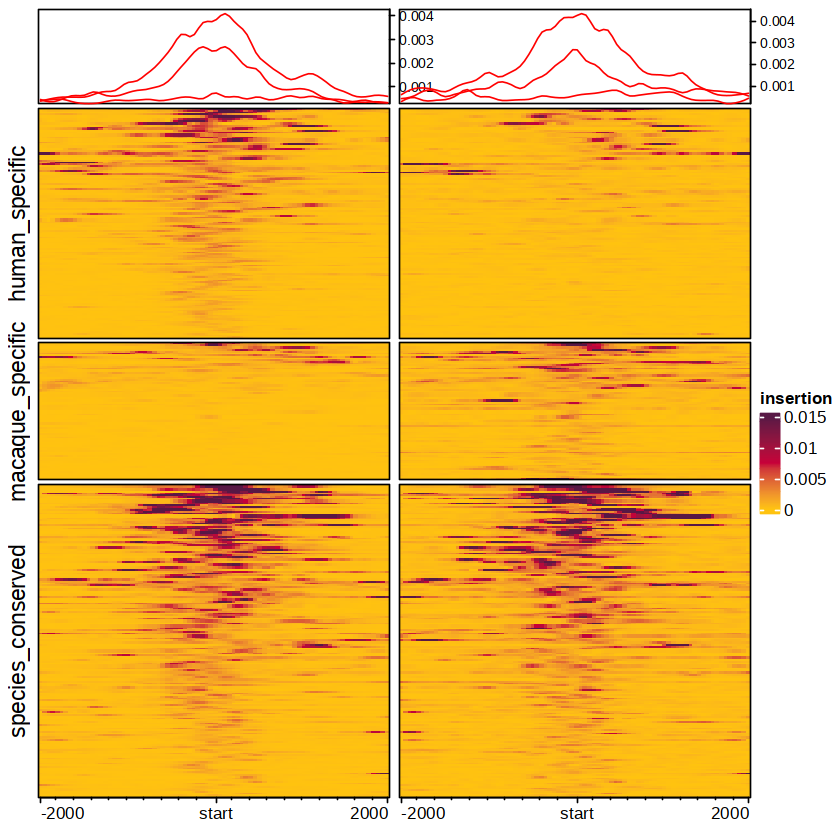

In [30]:
#plot
col_fun <- colorRamp2(breaks = c(0,0.0075,0.015),colors = c('#FFC30F','#C70039','#581845'))
EnrichedHeatmap(mat = p1@matrix,row_split = factor(group[rownames(p1@matrix),]$group,levels = c('human_specific','macaque_specific','species_conserved')),
                use_raster = TRUE,raster_resize_mat = mean,col = col_fun,name = 'insertion',pos_line = FALSE) + 
  EnrichedHeatmap(mat = p2@matrix,row_split = factor(group[rownames(p2@matrix),]$group,levels = c('human_specific','macaque_specific','species_conserved')),
                  use_raster = TRUE,raster_resize_mat = mean,col = col_fun,show_heatmap_legend = FALSE,pos_line = FALSE,row_order = p1@row_order)

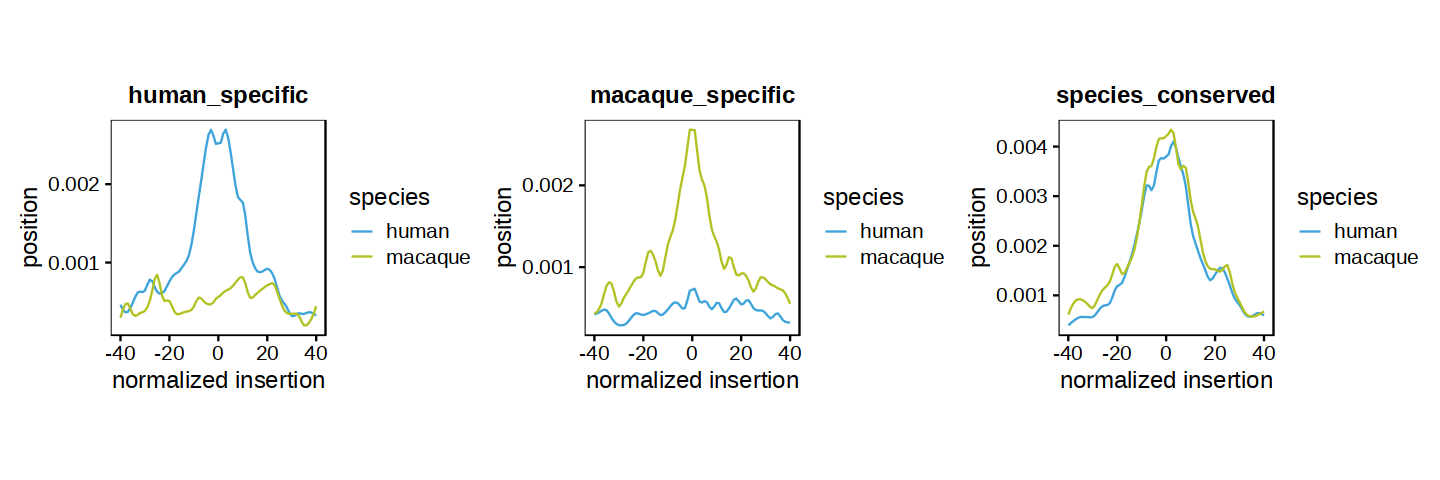

In [38]:
#dot line plot
group_list <- group

my_insertion_plot <- function(group,p1 = p1,p2 = p2){
  temp <- p1@matrix[group_list[rownames(p1@matrix),]$group == group,]
  temp <- colMeans(temp)
  temp <- data.frame(temp)
  temp$pos <- c(-40:-1,1:40)
  colnames(temp) <- c('insertion','pos')
  temp$species <- 'human'
  insertion_matrix <- temp
  
  temp <- p2@matrix[group_list[rownames(p2@matrix),]$group == group,]
  temp <- colMeans(temp)
  temp <- data.frame(temp)
  temp$pos <- c(-40:-1,1:40)
  colnames(temp) <- c('insertion','pos')
  temp$species <- 'macaque'
  insertion_matrix <- rbind(insertion_matrix,temp)
  
  p <- ggplot(data = insertion_matrix,aes(x=pos,y=insertion,color=species)) + 
    geom_point(alpha = 0) + 
    geom_line() + 
    theme_cowplot() + 
    scale_color_manual(values = color_param$species[c('human','macaque')]) + 
    theme(aspect.ratio = 1,
          panel.background = element_rect(fill = NA,colour = 'black'),
          axis.line = element_blank(),
          plot.title = element_text(face = 'bold',size = 14,hjust = 0.5)) + 
    labs(title = group) + xlab('normalized insertion') + ylab('position')
  return(p)
}

p_human <- my_insertion_plot(group = 'human_specific',p1 = p1,p2 = p2)
p_macaque <- my_insertion_plot(group = 'macaque_specific',p1 = p1,p2 = p2)
p_all <- my_insertion_plot(group = 'species_conserved',p1 = p1,p2 = p2)

options(repr.plot.width=12, repr.plot.height=4)
p_human+p_macaque+p_all+plot_layout(ncol = 3)

### generae all DF use for loop

In [ ]:
#load data
human_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_human_SNC.rds')
macaque_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_macaque_SNC.rds')

human_peak_matrix <- readRDS(file = './res/step_72_fig_221101/human_peak_matrix.rds')
macaque_peak_matrix <- readRDS(file = './res/step_72_fig_221101/macaque_peak_matrix.rds')

Greenleaf_ATAC_ArchR <- loadArchRProject(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/')
macaque_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/')

color_param <- readRDS(file = './data/parameter/shared_param/MetaValue_color_param_220923.rds')

In [ ]:
#generate cell type list
cell_type_list <- names(color_param$celltype)
cell_type_list <- cell_type_list[c(cell_type_list %in% Greenleaf_ATAC_ArchR$cell_type)]
cell_type_list <- cell_type_list[c(cell_type_list %in% macaque_multiome_ArchR$cell_type)]

In [ ]:
for (i in cell_type_list) {
  
  #set cell type
  cell_type <- i
  cell_type_dot <- gsub(pattern = '-',replacement = '.',x = cell_type,fixed = TRUE)
  
  #subset peak matrix cells
  human_cell_list <- rownames(Greenleaf_ATAC_ArchR@cellColData)[c(Greenleaf_ATAC_ArchR$cell_type == cell_type)]
  macaque_cell_list <- rownames(macaque_multiome_ArchR@cellColData)[c(macaque_multiome_ArchR$cell_type == cell_type)]
  
  subset_human_peak_matrix <- human_peak_matrix[,(human_cell_list)]
  subset_macaque_peak_matrix <- macaque_peak_matrix[,c(macaque_cell_list)]
  
  #generate normalize factor
  norm_factor <- c(Greenleaf_ATAC_ArchR@cellColData[c(human_cell_list),'ReadsInPeaks'],macaque_multiome_ArchR@cellColData[c(macaque_cell_list),'ReadsInPeaks'])
  norm_factor <- median(norm_factor) * 10^4
  
  #normalize
  subset_human_peak_matrix <- base::do.call(what = cbind,args = base::lapply(X = human_cell_list,FUN = function(x){
    temp <- subset_human_peak_matrix[,x]/Greenleaf_ATAC_ArchR@cellColData[x,'ReadsInPeaks']*norm_factor
    return(temp)
  }))
  colnames(subset_human_peak_matrix) <- human_cell_list
  rownames(subset_human_peak_matrix) <- rownames(human_peak_matrix)
  
  subset_macaque_peak_matrix <- base::do.call(what = cbind,args = base::lapply(X = macaque_cell_list,FUN = function(x){
    temp <- subset_macaque_peak_matrix[,x]/macaque_multiome_ArchR@cellColData[x,'ReadsInPeaks']*norm_factor
    return(temp)
  }))
  colnames(subset_macaque_peak_matrix) <- macaque_cell_list
  rownames(subset_macaque_peak_matrix) <- rownames(macaque_peak_matrix)
  
  #get peak list
  
  #human
  peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
  peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
  peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
  file.exists(peak_file) %>% print()
  peak_file <- readRDS(file = peak_file)
  
  names(human_SNC) <- paste(human_SNC@seqnames,as.character(human_SNC@ranges),sep = '-')
  temp <- countOverlaps(query = human_SNC,subject = peak_file)
  temp <- names(temp)[temp > 0]
  temp <- human_SNC[c(temp)]$human_SNC
  
  peak_list <- temp
  
  #macaque
  peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
  peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
  peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
  file.exists(peak_file) %>% print()
  peak_file <- readRDS(file = peak_file)
  
  names(macaque_SNC) <- paste(macaque_SNC@seqnames,as.character(macaque_SNC@ranges),sep = '-')
  temp <- countOverlaps(query = macaque_SNC,subject = peak_file)
  temp <- names(temp)[temp > 0]
  temp <- macaque_SNC[c(temp)]$human_SNC
  
  peak_list <- c(peak_list,temp)
  
  #unify
  peak_list <- unique(peak_list)
  
  #subset peak matrix peaks
  
  #human
  names(human_SNC) <- paste(human_SNC@seqnames,as.character(human_SNC@ranges),sep = '-')
  (rownames(subset_human_peak_matrix) %in% names(human_SNC)) %>% table()
  rownames(subset_human_peak_matrix) <- human_SNC[rownames(subset_human_peak_matrix)]$human_SNC
  subset_human_peak_matrix <- subset_human_peak_matrix[c(peak_list),]
  
  #macaque
  names(macaque_SNC) <- paste(macaque_SNC@seqnames,as.character(macaque_SNC@ranges),sep = '-')
  (rownames(subset_macaque_peak_matrix) %in% names(macaque_SNC)) %>% table()
  rownames(subset_macaque_peak_matrix) <- macaque_SNC[rownames(subset_macaque_peak_matrix)]$human_SNC
  subset_macaque_peak_matrix <- subset_macaque_peak_matrix[c(peak_list),]
  
  #run wilcox
  DF_list <- my_DF_wilcox_test(mat1 = subset_human_peak_matrix,mat2 = subset_macaque_peak_matrix,
                               alternative = 'two.sided',paired = FALSE,workers = 1,
                               future.globals.maxSize = 200*(1024^3))
  DF_list$human_SNC <- rownames(DF_list)
  
  #human specific
  human_specific_DF_list <- DF_list[c(DF_list$log2FC > 1 & DF_list$fdr < 0.01),]
  
  #intersect with human peaks
  peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
  peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
  peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
  file.exists(peak_file) %>% print()
  peak_file <- readRDS(file = peak_file)
  
  names(human_SNC) <- human_SNC$human_SNC
  temp <- countOverlaps(query = human_SNC,subject = peak_file)
  temp <- names(temp)[temp > 0]
  
  human_specific_DF_list <- human_specific_DF_list[c(human_specific_DF_list$human_SNC %in% temp),]
  human_specific_DF_list$group <- 'human_specific'
  
  #macaque specific
  macaque_specific_DF_list <- DF_list[c(DF_list$log2FC < -1 & DF_list$fdr < 0.01),]
  
  #intersect with macaque peaks
  peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
  peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
  peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
  file.exists(peak_file) %>% print()
  peak_file <- readRDS(file = peak_file)
  
  names(macaque_SNC) <- macaque_SNC$human_SNC
  temp <- countOverlaps(query = macaque_SNC,subject = peak_file)
  temp <- names(temp)[temp > 0]
  
  macaque_specific_DF_list <- macaque_specific_DF_list[c(macaque_specific_DF_list$human_SNC %in% temp),]
  macaque_specific_DF_list$group <- 'macaque_specific'
  
  #species conserved
  species_conserved_DF_list <- DF_list[c(abs(DF_list$log2FC) <= 1),]
  
  #intersect with human peaks
  peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
  peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
  peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
  file.exists(peak_file) %>% print()
  peak_file <- readRDS(file = peak_file)
  
  names(human_SNC) <- human_SNC$human_SNC
  temp <- countOverlaps(query = human_SNC,subject = peak_file)
  temp <- names(temp)[temp > 0]
  
  species_conserved_DF_list <- species_conserved_DF_list[c(species_conserved_DF_list$human_SNC %in% temp),]
  
  #intersect with macaque peaks
  peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
  peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
  peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
  file.exists(peak_file) %>% print()
  peak_file <- readRDS(file = peak_file)
  
  names(macaque_SNC) <- macaque_SNC$human_SNC
  temp <- countOverlaps(query = macaque_SNC,subject = peak_file)
  temp <- names(temp)[temp > 0]
  
  species_conserved_DF_list <- species_conserved_DF_list[c(species_conserved_DF_list$human_SNC %in% temp),]
  species_conserved_DF_list$group <- 'species_conserved'
  
  #save data
  DF_list <- rbind(human_specific_DF_list,macaque_specific_DF_list,species_conserved_DF_list)
  char <- paste0('./res/step_72_fig_221101/DF_list/',cell_type_dot,'_DF_list.rds')
  saveRDS(object = DF_list,file = char)
  
  #report
  char <- paste(cell_type,'done!',sep = ' ')
  print(char)
}

### generate all coverage plot for each cell type

In [ ]:
#load data
Greenleaf_ATAC_ArchR <- loadArchRProject(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/')
macaque_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/')
color_param <- readRDS(file = './data/parameter/shared_param/MetaValue_color_param_220923.rds')

In [ ]:
#generate cell type list
cell_type_list <- names(color_param$celltype)
cell_type_list <- cell_type_list[c(cell_type_list %in% Greenleaf_ATAC_ArchR$cell_type)]
cell_type_list <- cell_type_list[c(cell_type_list %in% macaque_multiome_ArchR$cell_type)]

In [ ]:
for (i in cell_type_list) {
  #load data
  cell_type <- i
  cell_type_dot <- gsub(pattern = '-',replacement = '.',x = cell_type,fixed = TRUE)
  
  group <- list.files(path = './res/step_72_fig_221101/DF_list')
  group <- group[c(grep(pattern = cell_type_dot,x = group,fixed = TRUE))]
  group <- paste('./res/step_72_fig_221101/DF_list',group,sep = '/')
  file.exists(group) %>% print()
  group <- readRDS(file = group)
  
  macaque_SNC <- readRDS(file = './res/step_72_fig_221101/macaque_lifted_SNC_after_seq_filter/extented_macaque_SNC.rds')
  
  #human
  target_site <- group$human_SNC
  target_site <- base::do.call(what = rbind,args = strsplit(x = target_site,split = '-'))
  target_site <- as.data.frame(target_site)
  colnames(target_site) <- c('chrom','start')
  target_site$end <- target_site$start
  target_site <- as(target_site,'GRanges')
  names(target_site) <- group$human_SNC
  
  signal_coverage <- list.files(path = './res/step_75_fig_221103/norm_by_ReadsInPeaks/human/GroupBigWigs/cell_type')
  signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
  signal_coverage <- paste('./res/step_75_fig_221103/norm_by_ReadsInPeaks/human/GroupBigWigs/cell_type',signal_coverage,sep = '/')
  signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
  mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                           value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)
  
  p1 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat),]$group,levels = c('human_specific','macaque_specific','species_conserved')),
                        use_raster = TRUE,raster_resize_mat = mean)
  #macaque
  names(macaque_SNC) <- macaque_SNC$human_SNC
  target_site <- macaque_SNC[c(group$human_SNC)]$macaque_SNC
  target_site <- base::do.call(what = rbind,args = strsplit(x = target_site,split = '-'))
  target_site <- as.data.frame(target_site)
  colnames(target_site) <- c('chrom','start')
  target_site$end <- target_site$start
  target_site <- as(target_site,'GRanges')
  names(target_site) <- group$human_SNC
  
  signal_coverage <- list.files(path = './res/step_75_fig_221103/norm_by_ReadsInPeaks/macaque/GroupBigWigs/cell_type')
  signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
  signal_coverage <- paste('./res/step_75_fig_221103/norm_by_ReadsInPeaks/macaque/GroupBigWigs/cell_type',signal_coverage,sep = '/')
  signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
  mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                           value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)
  
  p2 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat),]$group,levels = c('human_specific','macaque_specific','species_conserved')),
                        use_raster = TRUE,raster_resize_mat = mean)
  #plot
  col_fun <- colorRamp2(breaks = c(0,0.01,0.02),colors = c('#FFC30F','#C70039','#581845'))
  char <- paste0('./res/step_72_fig_221101/DF_list_coverage_plot/',cell_type_dot,'.enrichheatmap.pdf')
  pdf(file = char,width = 3.5,height = 5.5)
  print(EnrichedHeatmap(mat = p1@matrix,row_split = factor(group[rownames(p1@matrix),]$group,levels = c('human_specific','macaque_specific','species_conserved')),
                  use_raster = TRUE,raster_resize_mat = mean,col = col_fun,name = 'insertion',pos_line = FALSE) + 
    EnrichedHeatmap(mat = p2@matrix,row_split = factor(group[rownames(p2@matrix),]$group,levels = c('human_specific','macaque_specific','species_conserved')),
                    use_raster = TRUE,raster_resize_mat = mean,col = col_fun,show_heatmap_legend = FALSE,pos_line = FALSE,row_order = p1@row_order))
  dev.off()
  
  #dot line plot
  group_list <- group
  
  my_insertion_plot <- function(group,p1 = p1,p2 = p2){
    temp <- p1@matrix[group_list[rownames(p1@matrix),]$group == group,]
    temp <- colMeans(temp)
    temp <- data.frame(temp)
    temp$pos <- c(-40:-1,1:40)
    colnames(temp) <- c('insertion','pos')
    temp$species <- 'human'
    insertion_matrix <- temp
    
    temp <- p2@matrix[group_list[rownames(p2@matrix),]$group == group,]
    temp <- colMeans(temp)
    temp <- data.frame(temp)
    temp$pos <- c(-40:-1,1:40)
    colnames(temp) <- c('insertion','pos')
    temp$species <- 'macaque'
    insertion_matrix <- rbind(insertion_matrix,temp)
    
    p <- ggplot(data = insertion_matrix,aes(x=pos,y=insertion,color=species)) + 
      geom_point(alpha = 0) + 
      geom_line() + 
      theme_cowplot() + 
      scale_color_manual(values = color_param$species[c('human','macaque')]) + 
      theme(aspect.ratio = 1,
            panel.background = element_rect(fill = NA,colour = 'black'),
            axis.line = element_blank(),
            plot.title = element_text(face = 'bold',size = 14,hjust = 0.5)) + 
      labs(title = group) + xlab('normalized insertion') + ylab('position')
    return(p)
  }
  
  p_human <- my_insertion_plot(group = 'human_specific',p1 = p1,p2 = p2)
  p_macaque <- my_insertion_plot(group = 'macaque_specific',p1 = p1,p2 = p2)
  p_all <- my_insertion_plot(group = 'species_conserved',p1 = p1,p2 = p2)
  
  char <- paste0('./res/step_72_fig_221101/DF_list_coverage_plot/',cell_type_dot,'.dot_line_plot.pdf')
  pdf(file = char,width = 12,height = 4)
  print(p_human+p_macaque+p_all+plot_layout(ncol = 3))
  dev.off()
  
  #report 
  char <- paste(cell_type,'done!',sep = ' ')
  print(char)
}